In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
import scipy.cluster.hierarchy as sch
from scipy.sparse import dia_matrix

In [4]:
from IPython.display import display, HTML

In [5]:
import context
from hier_clust import linkage_util, HierClust
from hier_clust.tree_util import Tree

In [6]:
from gen_data_util import gen_data, plot_tree_overlay
from time_util import TimingRegistry

In [12]:
def analysis(depth, k = None, seed = None, run_top_down = True, run_bottom_up = True):
    reg = TimingRegistry()

    if seed is not None:
        np.random.seed(seed)

    n_obs = 2 ** depth
    n_dim = 10

    if k is None:
        k = int(max(n_obs * 0.1, 2))
    elif callable(k):
        k = k(n_obs)

    print("depth = {}, n_obs = {}, k = {}".format(depth, n_obs, k))

    with reg.timer("generate data") as timer:
        x, y = gen_data(depth = depth, n_dim = n_dim, depth_labels = 3)

    indices = np.arange(n_obs)
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    assert x.shape == (n_obs, n_dim)
    assert y.shape == (n_obs,)

    if run_top_down:
        hc = HierClust(n_neighbors=k, neighbor_graph_strategy='balltree')

        with reg.timer("distances") as timer:
            dist = hc._get_distances(x)
        with reg.timer("connected components") as timer:
            components = hc._get_connected_components(dist)
        with reg.timer("similarity") as timer:
            similarity = hc._get_similarity(dist)
        with reg.timer("compute laplacian") as timer:
            diag = similarity.sum(axis = 0)
            diag = dia_matrix((diag, [0]), (n_obs, n_obs)).tocsr()
            laplacian = diag - similarity
        with reg.timer("get_fiedler_vector") as timer:
            fiedler_vector = hc._get_fiedler_vector(laplacian)

        with reg.timer("fit") as timer:
            fit_result = hc.fit(x)

    if run_bottom_up:
        with reg.timer("complete linkage") as timer:
            link = sch.linkage(x, method='complete')
        with reg.timer("convert linkage to tree") as timer:
            t = linkage_util.linkage_to_tree(link)

    cols = ["n_obs", "k"]
    row = [n_obs, k]
    for key, val in reg.registry.items():
        cols.append(key)
        row.append(val)
    row = pd.Series(row, index = cols)
    
    return row

In [13]:
rows = []

In [ ]:
%%time
for depth in range(7, 15 + 1):
    row = analysis(depth = depth, k = 100, seed = 1)
    rows.append(row)

In [ ]:
row = analysis(depth = 16, k = 100, seed = 1, run_bottom_up = False)
rows.append(row)

In [9]:
row = analysis(depth = 17, k = 100, seed = 1, run_bottom_up = False)
rows.append(row)

depth = 17, n_obs = 131072, k = 100
Elapsed time: 4.727 seconds (generate data)
Elapsed time: 95.899 seconds (distances)
Elapsed time: 17.192 seconds (connected components)
Elapsed time: 4.358 seconds (similarity)
Elapsed time: 0.177 seconds (compute laplacian)
Elapsed time: 10.667 seconds (get_fiedler_vector)
Elapsed time: 596.655 seconds (fit)


In [14]:
row = analysis(depth = 18, k = 100, seed = 1, run_bottom_up = False)
rows.append(row)

depth = 18, n_obs = 262144, k = 100
Elapsed time: 9.434 seconds (generate data)
Elapsed time: 207.049 seconds (distances)
Elapsed time: 33.381 seconds (connected components)
Elapsed time: 7.622 seconds (similarity)
Elapsed time: 0.379 seconds (compute laplacian)
Elapsed time: 23.806 seconds (get_fiedler_vector)
Elapsed time: 1201.101 seconds (fit)


In [ ]:
row = analysis(depth = 16, k = 100, seed = 1, run_top_down = False)
rows.append(row)

depth = 16, n_obs = 65536, k = 100


In [15]:
summary = pd.DataFrame.from_records(rows)
summary = summary.loc[:, rows[0].index]
display(HTML(summary.to_html(index = False)))

n_obs,k,generate data,distances,connected components,similarity,compute laplacian,get_fiedler_vector,fit
262144.0,100.0,9.434421,207.049096,33.380661,7.62152,0.379359,23.806396,1201.10073


In [17]:
summary = pd.read_csv('/Users/aleverentz/Desktop/temp_stats_for_plotting.csv')

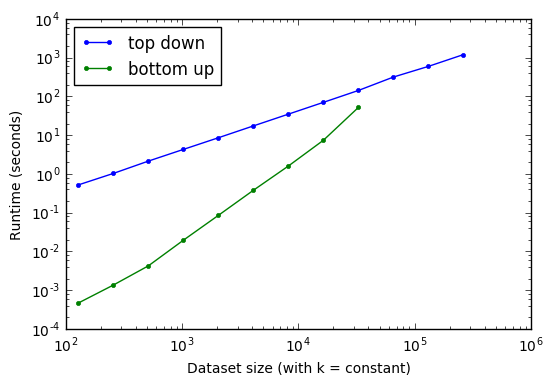

In [22]:
fig, ax = plt.subplots()
ax.loglog(summary["n_obs"], summary["fit"], label = "top down", marker='.')
ax.loglog(summary["n_obs"], summary["complete linkage"], label = "bottom up", marker='.')

ax.set_ylabel('Runtime (seconds)')
ax.set_xlabel('Dataset size (with k = constant)')
ax.legend(loc='best')

None

In [ ]:
# fig, ax = plt.subplots()
# for yi in np.unique(y):
#     ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
# plot_tree_overlay(data = x, tree = fit_result[0], max_depth = 10, ax = ax)

# None

##### Cleanup

In [ ]:
plt.close()